In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
num_games = 2

Text(0.5, 1.0, 'Distribution of Fantasy Points')

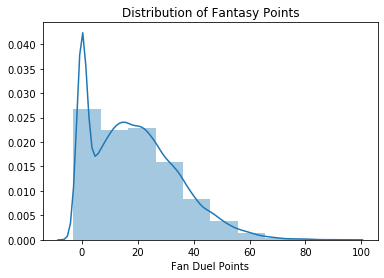

In [3]:
full_df = pd.read_csv(f'../Data/CompleteMerge(2018-2020)[{num_games}].csv').dropna()
col = ['MP', 'FG', 'FGA', '3P', '3PA',
        'FT', 'FTA', 'TRB', 'AST', 'STL', 'BLK',
        'PTS', '+-', 'FDP']
x_col = [f'{num_games}_{i}' for i in col] 
X = np.array(full_df[[i for i in x_col]])
y = np.array(full_df[['FDP']])

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = .8)

sns.distplot(y, bins = 10)
plt.xlabel('Fan Duel Points'); plt.title('Distribution of Fantasy Points')

## Linear Model

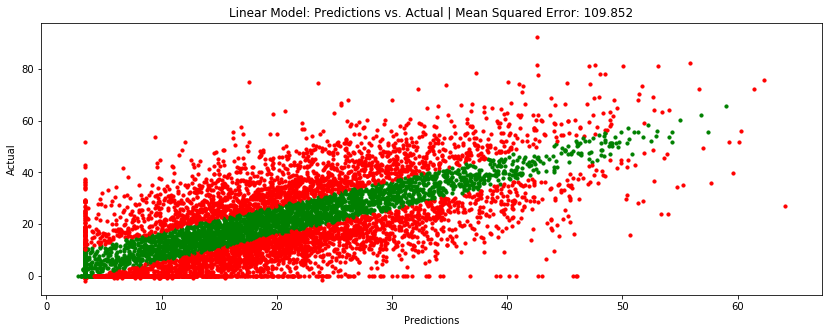

In [4]:
from sklearn.linear_model import LinearRegression 

#initialize object
linear = LinearRegression()

#fit x_train and y_train to model
linear.fit(x_train, y_train)

#make predictions using x_test and y_test
linear_predictions = linear.predict(x_test)

#plot the actual vs predicted
plt.figure(figsize = (14,5))
actual_predict = list(zip(linear_predictions, y_test))
s_diff = 0
for i in actual_predict: 
    predict = i[0][0]
    actual = i[1][0]
    diff = predict - actual
    if abs(actual - predict) <= 7 and actual - predict > -4: 
        color = 'green' #good prediction
    else: 
        color = 'red'   #bad prediction
    plt.scatter(predict, actual, s=10, c = color)
    s_diff += diff**2
loss = round(s_diff/len(actual_predict),3)
plt.title(f'Linear Model: Predictions vs. Actual | Mean Squared Error: {loss}')
plt.xlabel('Predictions'); plt.ylabel('Actual')
plt.savefig('LinearScatter.png')

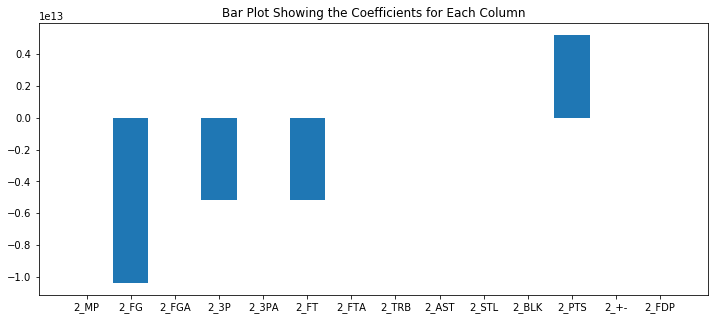

In [5]:
input_variables = full_df[[i for i in x_col]].columns.to_list()

coeff = linear.coef_[0]
plt.figure(figsize = (12,5))
plt.bar(input_variables, coeff)
plt.title('Bar Plot Showing the Coefficients for Each Column')
plt.savefig('LinearCoefficients.png')

# Neural Networks

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.models import model_from_json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasRegressor


num_games = 2
epochs = 50 
batches = 16

In [7]:
full_df = pd.read_csv(f'../Data/CompleteMerge(2018-2020)[{num_games}].csv').dropna()
col = ['MP', 'FG', 'FGA', '3P', '3PA',
        'FT', 'FTA', 'TRB', 'AST', 'STL', 'BLK',
        'PTS', 'FDP']
x_col = [f'{num_games}_{i}' for i in col] 
X = np.array(full_df[[i for i in x_col]])
y = np.array(full_df[['FDP']])

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = .8)

min_max = MinMaxScaler()
standard= StandardScaler()
x_train = min_max.fit_transform(x_train)
x_test = min_max.fit_transform(x_test)

### Sequential AAN

In [8]:
def sequential_AAN(x,y, metrics = ['accuracy', 'mse']): 
    drop = .1

    model = Sequential()
    
    model.add(Dense(x.shape[1],input_dim = x.shape[1], activation = 'relu'))
    model.add(Dropout(drop)) #regularization

    
    model.add(Dense(128 , activation = 'relu'))
    model.add(Dropout(drop))

    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(drop)) 
    
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(drop)) 

    
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss = 'mae', optimizer = 'adam', metrics = metrics)
    return model

In [9]:
seq_ann = sequential_AAN(x_train, y_train)
ann_history = seq_ann.fit(x_train, y_train, epochs = epochs, batch_size = batches, validation_data= (x_test,y_test))
# json = open('models/ANN_Model.json', 'r')
# ann_json = json.read()
# json.close()
# seq_ann = model_from_json(ann_json)
# seq_ann.load_weights('models/ANN_Model_Weights.h5')

Epoch 1/50
2240/2240 [==============================] - 3s 1ms/step - loss: 8.5417 - accuracy: 0.0794 - mse: 135.4500 - val_loss: 8.0563 - val_accuracy: 0.1116 - val_mse: 124.4660
Epoch 2/50
2240/2240 [==============================] - 2s 1ms/step - loss: 8.1397 - accuracy: 0.1028 - mse: 123.1005 - val_loss: 7.7693 - val_accuracy: 0.0998 - val_mse: 112.4014
Epoch 3/50
2240/2240 [==============================] - 2s 1ms/step - loss: 8.1133 - accuracy: 0.1052 - mse: 123.1753 - val_loss: 7.7410 - val_accuracy: 0.1064 - val_mse: 112.3850
Epoch 4/50
2240/2240 [==============================] - 2s 1ms/step - loss: 8.0766 - accuracy: 0.1059 - mse: 121.7715 - val_loss: 8.0534 - val_accuracy: 0.1044 - val_mse: 123.2215
Epoch 5/50
2240/2240 [==============================] - 2s 1ms/step - loss: 8.0598 - accuracy: 0.1073 - mse: 121.7916 - val_loss: 8.1165 - val_accuracy: 0.1188 - val_mse: 126.8653
Epoch 6/50
2240/2240 [==============================] - 2s 1ms/step - loss: 8.0684 - accuracy: 0.109

2240/2240 [==============================] - 2s 1ms/step - loss: 7.9506 - accuracy: 0.1118 - mse: 118.5908 - val_loss: 7.7600 - val_accuracy: 0.1188 - val_mse: 114.8725
Epoch 47/50
2240/2240 [==============================] - 2s 1ms/step - loss: 7.9668 - accuracy: 0.1127 - mse: 119.1405 - val_loss: 7.7058 - val_accuracy: 0.1124 - val_mse: 111.4885
Epoch 48/50
2240/2240 [==============================] - 2s 1ms/step - loss: 7.9504 - accuracy: 0.1122 - mse: 118.5972 - val_loss: 7.8920 - val_accuracy: 0.1182 - val_mse: 119.7694
Epoch 49/50
2240/2240 [==============================] - 2s 1ms/step - loss: 7.9385 - accuracy: 0.1121 - mse: 118.5172 - val_loss: 7.8053 - val_accuracy: 0.1189 - val_mse: 116.6953
Epoch 50/50
2240/2240 [==============================] - 2s 1ms/step - loss: 7.9427 - accuracy: 0.1098 - mse: 118.3945 - val_loss: 7.9593 - val_accuracy: 0.1163 - val_mse: 121.9601


In [10]:
ann_json = seq_ann.to_json()
with open('models/ANN_Model.json', 'w') as file:
    file.write(ann_json)
    
seq_ann.save('models/ANN_Model_Weights.h5')

dict_keys(['loss', 'accuracy', 'mse', 'val_loss', 'val_accuracy', 'val_mse'])


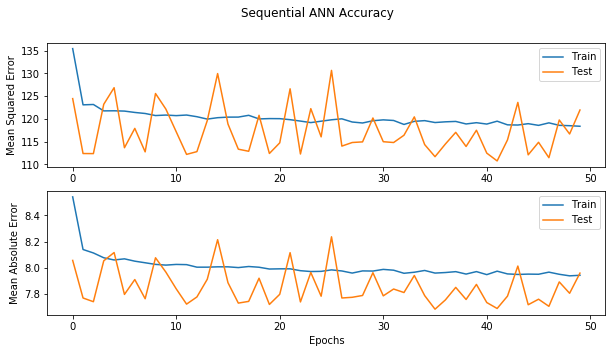

In [11]:
#Plotting the losses for ANN
print(ann_history.history.keys())
ann_df = pd.DataFrame(ann_history.history)
ann_df.tail(5)
fig, ax = plt.subplots(2, figsize = (10,5))
ax[0].plot(ann_df.index, ann_df.mse, label = 'Train')
ax[0].plot(ann_df.index, ann_df.val_mse, label = 'Test')
ax[0].legend()
ax[0].set_ylabel('Mean Squared Error')

ax[1].plot(ann_df.index, ann_df.loss, label = 'Train')
ax[1].plot(ann_df.index, ann_df.val_loss, label = 'Test')
ax[1].legend()
ax[1].set_ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.suptitle('Sequential ANN Accuracy')
plt.savefig('ANNLoss.png')

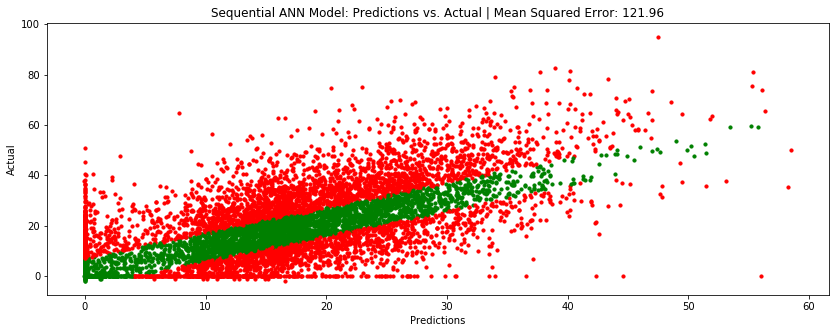

In [12]:
#make predictions using x_test and y_test for ANN
ann_predictions = seq_ann.predict(x_test)

#plot the actual vs predicted
plt.figure(figsize = (14,5))
actual_predict = list(zip(ann_predictions, y_test))
s_diff = 0
for i in actual_predict: 
    predict = i[0][0]
    actual = i[1][0]
    diff = predict - actual
    if abs(actual - predict) <= 7 and actual - predict > -4:  
        color = 'green' #good prediction
    else: 
        color = 'red'   #bad prediction
    plt.scatter(predict, actual, s=10, c = color)
    s_diff += diff**2
loss = round(s_diff/len(actual_predict),3)
plt.title(f'Sequential ANN Model: Predictions vs. Actual | Mean Squared Error: {loss}')
plt.xlabel('Predictions'); plt.ylabel('Actual')
plt.savefig('ANNScatter.png')

### Multvariate RNN (LSTM)

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.models import model_from_json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math




num_games = 2
epochs = 50 
batches = 16

full_df = pd.read_csv(f'../Data/CompleteMerge(2018-2020)[{num_games}].csv').dropna()
col = ['MP', 'FG', 'FGA', '3P', '3PA',
        'FT', 'FTA', 'TRB', 'AST', 'STL', 'BLK',
        'PTS', 'FDP']
x_col = [f'{num_games}_{i}' for i in col] + ['FDS','FD_change']
min_max= MinMaxScaler()
standard = StandardScaler()

X = np.array(full_df[[i for i in x_col]])
y = np.array(full_df[['FDP']])
# y = np.array(full_df.FDP.map(lambda x: int(math.ceil(x/10))* 10))
# fds_fdp = list(zip(np.array(full_df.FDS/1000), np.array(full_df.FDP)))
# y = np.array(list(map(lambda x: round(x[1]/x[0],2), fds_fdp)))
# time = 10
# size = X.shape[0]-(X.shape[0] % time)
# X = X[:size]
# X = X.reshape(X.shape[0]//time, time, X.shape[1])
# y = y[:size+1]
# y = y[range(time,len(y), time)]



x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = .8)

x_train = min_max.fit_transform(x_train)
x_test = min_max.fit_transform(x_test)
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_train = x_train.reshape((x_train.shape[0],1, x_train.shape[1]))

In [14]:
def multivar_RNN(x,y, metrics = ['accuracy', 'mse']): 
    model = Sequential()
    units = 128
    drop = .1
    
    #first type
    
#     model.add(LSTM(units, return_sequences = True, input_shape = (1,x.shape[2]),activation = 'relu'))
#     model.add(Dropout(drop))
#     model.add(LSTM(units, return_sequences = True, input_shape = (1,x.shape[2]),activation = 'relu'))
#     model.add(Dropout(drop))
#     model.add(LSTM(units, return_sequences = False, input_shape = (1,x.shape[2]),activation = 'relu'))
#     model.add(Dropout(drop))



    #2nd type
    model.add(LSTM(units, return_sequences = True, input_dim = x.shape[2], activation = 'relu'))
    model.add(Dropout(drop))
    model.add(LSTM(units = units, return_sequences = True, input_dim = x.shape[2], activation = 'relu'))
    model.add(Dropout(drop))
    model.add(LSTM(units = units, return_sequences = False, input_dim = x.shape[2], activation = 'relu'))
    model.add(Dropout(drop))


 
    
    model.add(Dense(1, activation = 'linear'))
    
    model.compile(optimizer = 'adam', loss = 'mae', metrics = metrics)
    
    return model
        

In [15]:
mult_rnn = multivar_RNN(x_train, y_train)
rnn_history = mult_rnn.fit(x_train, y_train, epochs = epochs, batch_size = batches, validation_data= (x_test,y_test))

Epoch 1/50
2240/2240 [==============================] - 7s 3ms/step - loss: 8.2349 - accuracy: 0.0407 - mse: 125.7345 - val_loss: 7.5942 - val_accuracy: 0.0017 - val_mse: 103.2537
Epoch 2/50
2240/2240 [==============================] - 7s 3ms/step - loss: 7.5788 - accuracy: 0.0892 - mse: 106.5320 - val_loss: 7.6008 - val_accuracy: 0.0709 - val_mse: 106.0996
Epoch 3/50
2240/2240 [==============================] - 7s 3ms/step - loss: 7.4949 - accuracy: 0.0959 - mse: 105.1758 - val_loss: 7.4662 - val_accuracy: 0.0865 - val_mse: 102.9198
Epoch 4/50
2240/2240 [==============================] - 7s 3ms/step - loss: 7.4773 - accuracy: 0.1002 - mse: 105.1874 - val_loss: 7.6330 - val_accuracy: 0.0770 - val_mse: 105.6218
Epoch 5/50
2240/2240 [==============================] - 7s 3ms/step - loss: 7.4388 - accuracy: 0.1020 - mse: 104.3220 - val_loss: 7.4208 - val_accuracy: 0.0879 - val_mse: 101.9284
Epoch 6/50
2240/2240 [==============================] - 7s 3ms/step - loss: 7.4464 - accuracy: 0.102

2240/2240 [==============================] - 7s 3ms/step - loss: 7.3473 - accuracy: 0.1081 - mse: 103.1283 - val_loss: 7.5317 - val_accuracy: 0.0965 - val_mse: 104.2991
Epoch 47/50
2240/2240 [==============================] - 7s 3ms/step - loss: 7.3561 - accuracy: 0.1088 - mse: 102.9207 - val_loss: 7.5875 - val_accuracy: 0.1119 - val_mse: 109.2125
Epoch 48/50
2240/2240 [==============================] - 7s 3ms/step - loss: 7.3421 - accuracy: 0.1100 - mse: 102.7046 - val_loss: 7.6950 - val_accuracy: 0.1088 - val_mse: 112.3893
Epoch 49/50
2240/2240 [==============================] - 7s 3ms/step - loss: 7.3362 - accuracy: 0.1097 - mse: 102.5204 - val_loss: 7.5593 - val_accuracy: 0.1030 - val_mse: 108.1538
Epoch 50/50
2240/2240 [==============================] - 7s 3ms/step - loss: 7.3574 - accuracy: 0.1082 - mse: 102.8593 - val_loss: 7.5153 - val_accuracy: 0.1087 - val_mse: 106.4415


In [16]:
rnn_json = mult_rnn.to_json()
with open('models/RNN_Model.json', 'w') as file:
    file.write(rnn_json)
mult_rnn.save('models/RNN_Model_weights.h5')

# json = open('models/RNN_Model.json', 'r')
# rnn_json = json.read()
# json.close()
# mult_rnn = model_from_json(rnn_json)
# mult_rnn.load_weights('models/RNN_Model_Weights.h5')

dict_keys(['loss', 'accuracy', 'mse', 'val_loss', 'val_accuracy', 'val_mse'])


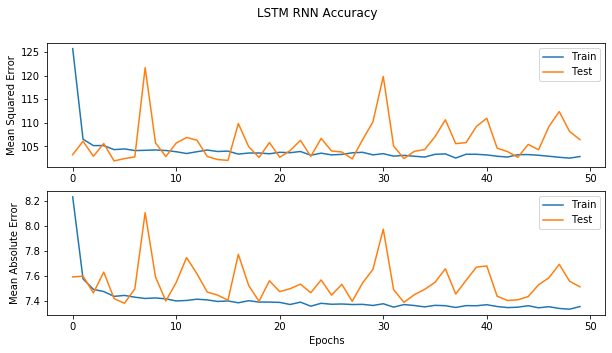

In [17]:
print(rnn_history.history.keys())
rnn_df = pd.DataFrame(rnn_history.history)
rnn_df.tail(5)
fig, ax = plt.subplots(2, figsize = (10,5))
ax[0].plot(rnn_df.index, rnn_df.mse, label = 'Train')
ax[0].plot(rnn_df.index, rnn_df.val_mse, label = 'Test')
ax[0].legend()
ax[0].set_ylabel('Mean Squared Error')

ax[1].plot(rnn_df.index, rnn_df.loss, label = 'Train')
ax[1].plot(rnn_df.index, rnn_df.val_loss, label = 'Test')
ax[1].legend()
ax[1].set_ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.suptitle('LSTM RNN Accuracy')
plt.savefig('RNNLoss.png')

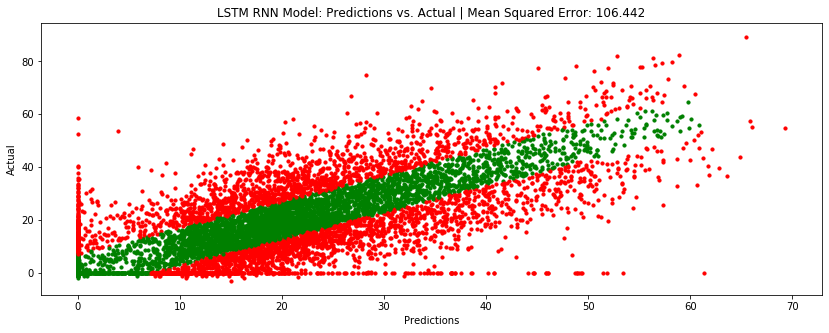

In [18]:
#make predictions using x_test and y_test for ANN
rnn_predictions = mult_rnn.predict(x_test)

#plot the actual vs predicted
plt.figure(figsize = (14,5))
actual_predict = list(zip(rnn_predictions, y_test))
s_diff = 0
for i in actual_predict: 
    predict = i[0][0]
    actual = i[1][0]
    diff = predict - actual
    if abs(diff) <= 7: 
        color = 'green' #good prediction
    else: 
        color = 'red'   #bad prediction
    plt.scatter(predict, actual, s=10, c = color)
    s_diff += diff**2
loss = round(s_diff/len(actual_predict),3)
plt.title(f'LSTM RNN Model: Predictions vs. Actual | Mean Squared Error: {loss}')
plt.xlabel('Predictions'); plt.ylabel('Actual')
plt.savefig('RNNScatter.png')